Данные по станциям метро взяла отсюда: <br>
<a href='https://gist.github.com/altsoph/56c38e76bae853655b962979346d194e'>routes_data</a><br>
<a href='https://gist.github.com/altsoph/6d3bfc97e26a4614d07fa74657739163'>stations_data</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import Dict, List

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
STATIONS = 'data/stations_data.tsv'

stations_base = pd.read_csv(STATIONS, sep='\t')
stations = stations_base.copy()
stations.shape

(194, 9)

In [3]:
stations.head()

,id,line_name,station_name,station_type,delay_morning,delay_rush,delay_night,lat,lon
0,0,Сокольническая,Бульвар Рокоссовского,deadend,120,90,360,55.814269,37.735117
1,1,Сокольническая,Черкизовская,pass,120,90,360,55.802991,37.744825
2,2,Сокольническая,Преображенская площадь,pass,120,90,360,55.796172,37.715022
3,3,Сокольническая,Сокольники,pass,120,90,360,55.789200,37.679706
4,4,Сокольническая,Красносельская,pass,120,90,360,55.779853,37.666077


In [4]:
stations_data = stations[['id', 'station_name', 'line_name']]
stations_data.head()

,id,station_name,line_name
0,0,Бульвар Рокоссовского,Сокольническая
1,1,Черкизовская,Сокольническая
2,2,Преображенская площадь,Сокольническая
3,3,Сокольники,Сокольническая
4,4,Красносельская,Сокольническая


In [5]:
stations_data.to_csv(r'stations_data.txt', header=None, index=None, sep=',', mode='a')

In [6]:
stations_data[['station_name', 'line_name']].duplicated().sum()

0

In [7]:
stations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            194 non-null    int64 
 1   station_name  194 non-null    object
 2   line_name     194 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB


In [8]:
N = stations.shape[0]
print(f'Всего станций: {N}')

Всего станций: 194


In [9]:
ROUTES = 'data/routes_data.tsv'

routes_base = pd.read_csv(ROUTES, sep='\t')
routes = routes_base.copy()
routes.shape

(456, 8)

In [10]:
routes.head()

,id_from,id_to,line_from,station_from,line_to,station_to,route_type,delay
0,0,1,Сокольническая,Бульвар Рокоссовского,Сокольническая,Черкизовская,drive,120
1,1,0,Сокольническая,Черкизовская,Сокольническая,Бульвар Рокоссовского,drive,120
2,1,2,Сокольническая,Черкизовская,Сокольническая,Преображенская площадь,drive,240
3,2,1,Сокольническая,Преображенская площадь,Сокольническая,Черкизовская,drive,240
4,2,3,Сокольническая,Преображенская площадь,Сокольническая,Сокольники,drive,180


In [11]:
stations_matrix = np.zeros((N, N), dtype=int)
stations_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
ids_from = routes['id_from']
ids_to = routes['id_to']

for i in range(len(ids_from)):
    stations_matrix[ids_from[i]][ids_to[i]] = 1
stations_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [13]:
np.savetxt('stations_matrix.txt', stations_matrix, fmt='%i', delimiter=' ')

In [14]:
line_color = {
    'Сокольническая': 'tab:red',
    'Замоскворецкая': 'tab:green',
    'Арбатско-Покровская': 'tab:blue',
    'Филевская': 'deepskyblue',
    'Кольцевая': 'tab:brown',
    'Калужско-Рижская': 'tab:orange',
    'Таганско-Краснопресненская': 'tab:purple', 
    'Калининская': 'gold',
    'Серпуховско-Тимирязевская': 'gray', 
    'Люблинско-Дмитровская': 'yellowgreen',
    'Каховская': 'paleturquoise', 
    'Бутовская': 'lightblue', 
    'Монорельс': 'royalblue'
}

In [15]:
def metro_graph(stations: pd.DataFrame, routes: pd.DataFrame) -> nx.Graph:
    """
    Build a graph with metro stations and routes
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph
    :param routes: edgelist for undeground graph. id_from is source and id_to is target nodes.
    :return: graph of Moscow undeground
    """
    G = nx.Graph()
    G.add_nodes_from(stations.id)
    edges = routes[['id_from', 'id_to']].values
    G.add_edges_from(edges)
    nx.set_node_attributes(G, stations['station_name'].to_dict(), 'station_name')
    nx.set_node_attributes(G, stations['line_name'].to_dict(), 'line_name')
    return G

def metro_layout(stations: pd.DataFrame) -> Dict[int, List[float]]:
    """
    Build a distance based layout of the metro graph
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph.
        lat and lon is geo coordinates of station.
    :return: geo layout of Moscow undeground
    """
    return {int(id):[lon, lat] for id, lon, lat in stations[['id', 'lon', 'lat']].values}
    
def station_color(G: nx.Graph, line_color: Dict[str, str] = line_color) -> Dict[int, str]:
    """
    Defines color of stations
    
    :param G: graph of Moscow undeground
    :param line_color: mapping of undeground lines to colors
    :return: mapping of node ids to its colors 
    """
    return {node:line_color[l] for node, l in nx.get_node_attributes(G, 'line_name').items()}

In [16]:
G = metro_graph(stations, routes)
pos = metro_layout(stations)
nx.set_node_attributes(G, station_color(G), 'color')

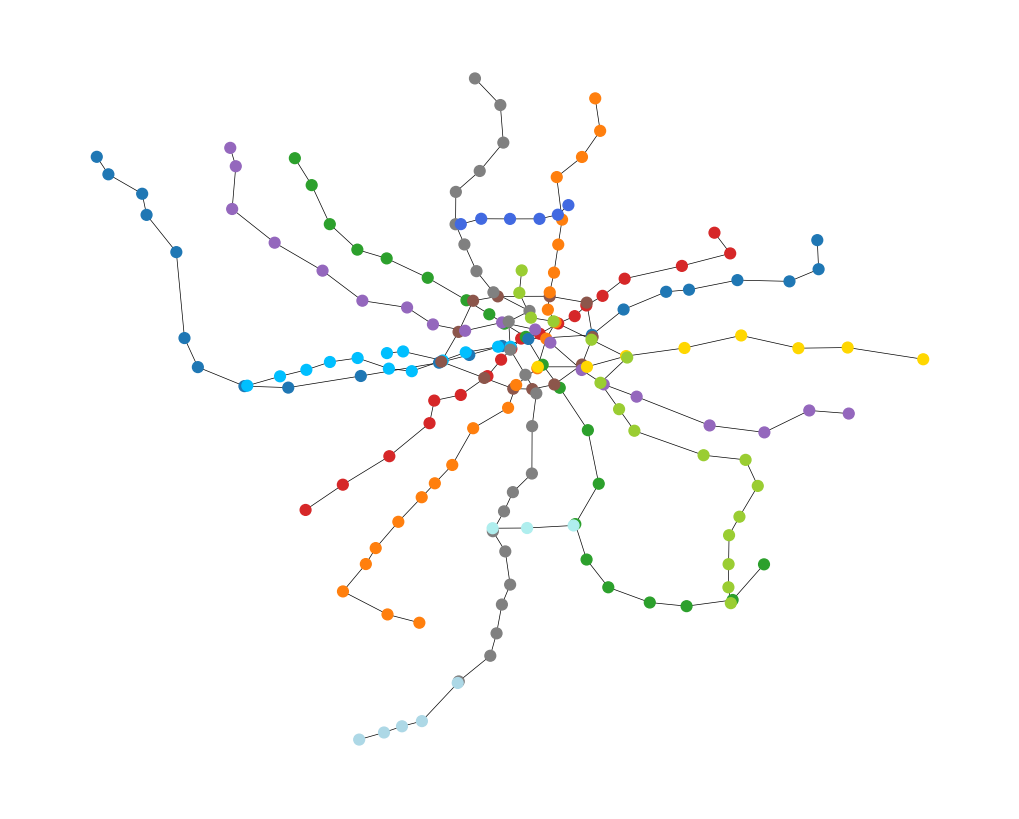

In [17]:
plt.figure(figsize=(10, 8))
nx.draw(
    G, 
    pos,
    width=0.5,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    node_size=60,
)
plt.savefig('subway.png')
plt.show()